# **Imports**


In [1]:
# Custom libraries
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.CNNPreprocessor import CNNPreprocessor
from tools.CNNTrainer import CNNTrainer
from tools.CNNEvaluator import CNNEvaluator


# Custom PyTorch models
from models.PyTorchCNNClassifier import PyTorchCNNClassifier

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


# **Data Load**


In [3]:
# Initialize the data loader for a train dataset
train_loader = DataLoader(dataset_type="train", path="./db/seg_train")
train_dataset = train_loader.load_data()

# Initialize the data loader for a test dataset
test_loader = DataLoader(dataset_type="test", path="./db/seg_test")
test_dataset = test_loader.load_data()

# # Initialize the data loader for a val dataset
# val_loader = DataLoader(dataset_type="val", path="./db/seg_pred")
# val_dataset = val_loader.load_unlabeled_data()

In [4]:
print(f"Train dataset type: {type(train_dataset)}")
print(f"Test dataset type: {type(test_dataset)}")
# print(f"Val dataset type: {type(val_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


# **EDA**


In [5]:
eda = EDA(train_dataset, train_dataset.classes)

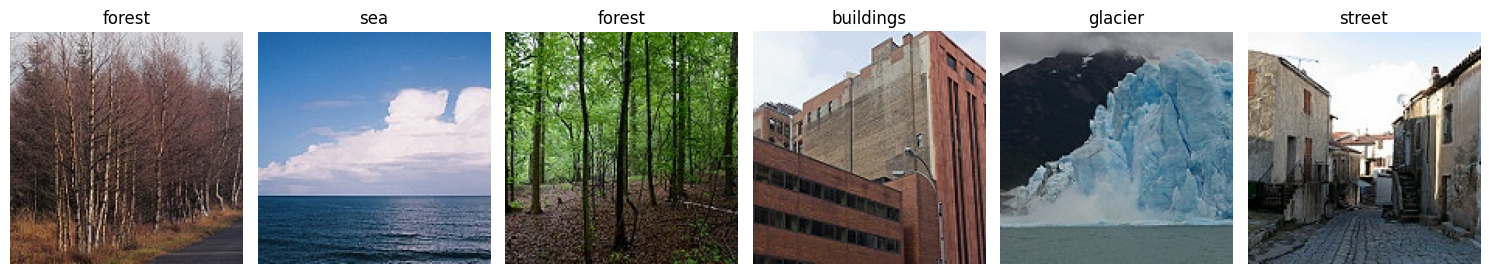

In [6]:
eda.show_sample_images(num_images=6)

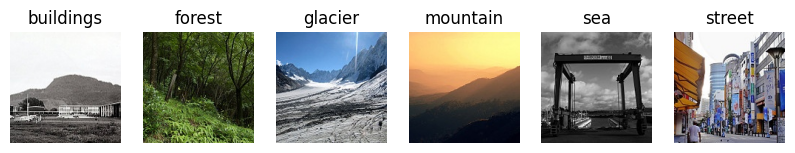

In [7]:
eda.show_images_from_each_class()

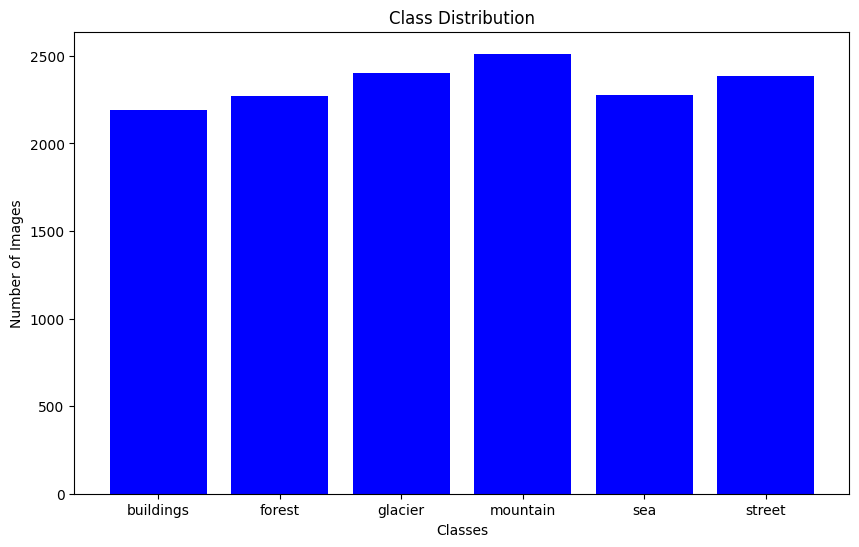

In [8]:
eda.plot_class_distribution()

In [9]:
eda.show_image_shape()

Shape of an image: torch.Size([3, 150, 150])


# **Preprocessing**


In [10]:
preprocessor = CNNPreprocessor()

In [11]:
preprocessor.help()

Available transformations and their parameters:
+----------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------+
| Transformation       | Description                                                                  | Parameters                                                         |
+======================+==============================================================================+====================================================================+
| ToGray               | Converts the image to grayscale.                                             | None: No parameters. Converts to grayscale using luminance.        |
+----------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------+
| RandomResizedCrop    | Randomly crops a part of the image and resizes it to the given

In [12]:
preprocessor.set_transform_settings(
    train_transform_settings={
        "RandomResizedCrop": {"enabled": True, "size": 224},
        "RandomHorizontalFlip": {"enabled": True, "p": 0.5},
        # "VerticalFlip": {"enabled": True, "p": 0.5},
        # "ColorJitter": {
        #     "enabled": True,
        #     "brightness": 0.5,
        #     "contrast": 0.5,
        #     "saturation": 0.5,
        #     "hue": 0.2,
        # },
        # "GaussianBlur": {"enabled": True, "kernel_size": (5, 9), "sigma": (0.1, 5)},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    test_transform_settings={
        "Resize": {"enabled": True, "size": 256},
        "CenterCrop": {"enabled": True, "size": 224},
        "ToTensor": {"enabled": True},
        "Normalize": {
            "enabled": True,
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
        },
    },
    # val_transform_settings={
    #     "Normalize": {
    #         "enabled": True,
    #         "mean": [0.485, 0.456, 0.406],
    #         "std": [0.229, 0.224, 0.225],
    #     },
    # },
)

In [13]:
img_train, label_img_train = train_dataset[0]
img_test, label_test = test_dataset[0]
# img_val = val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
# print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>


In [14]:
transformed_train_dataset = preprocessor.transform_dataset(
    train_dataset, dataset_type="train"
)

transformed_test_dataset = preprocessor.transform_dataset(
    test_dataset, dataset_type="test"
)

In [15]:
print(f"Train dataset type: {type(transformed_train_dataset)}")
print(f"Test dataset type: {type(transformed_test_dataset)}")

Train dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Test dataset type: <class 'torchvision.datasets.folder.ImageFolder'>


In [16]:
# transformed_val_dataset = preprocessor.transform_unlabeled_data(val_dataset)

In [17]:
# print(f"Val dataset type: {type(transformed_val_dataset)}")

In [18]:
img_train, label_img_train = transformed_train_dataset[0]
img_test, label_test = transformed_test_dataset[0]
# img_val = transformed_val_dataset[0]

print(f"Image type train: {type(img_train)}")
print(f"Image type test: {type(img_test)}")
# print(f"Image type val: {type(img_val)}")

Image type train: <class 'torch.Tensor'>
Image type test: <class 'torch.Tensor'>


In [19]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [20]:
model = PyTorchCNNClassifier(
    input_channels=3, num_classes=num_classes, random_state=42, epochs_logger=True
)

In [21]:
param_grid = {
    "conv_layers": [[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]],
    "hidden_sizes": [[256, 128]],
    "lr": [0.001],
    "batch_size": [16],
    "epochs": [50],
    "dropout_rate": [0.1],
    "optimizer_type": ["adam"],
    "activation_fn": ["ReLU"],
    "pool_fn": ["AvgPool2d"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "pool_padding": [1],
}

In [22]:
models = {"cnn_model": model}
param_grids = {"cnn_model": param_grid}

# **Model Training**


In [23]:
model_trainer = CNNTrainer(device="cuda")

In [24]:
model_trainer.help()

=== CNNTrainer Help ===
This trainer is designed to support classification tasks using PyTorch CNN models.

Usage:
1. Initialize the CNNTrainer with the device ('cpu' or 'cuda').
   Example:
       trainer = CNNTrainer(device='cuda')

2. Create model objects and define the parameter grid for hyperparameter tuning.
   Example:
       param_grid = { "lr": [0.001, 0.01], "epochs": [10, 20] }

3. Call the `train` method with the training and test datasets, models, and parameter grid.
   Example:
       trainer.train(train_dataset, test_dataset, models={'cnn_model': model}, param_grids={'cnn_model': param_grid})


In [25]:
model_trainer.train(
    train_dataset=transformed_train_dataset,
    test_dataset=transformed_test_dataset,
    models=models,
    param_grids=param_grids,
    scoring="accuracy",
    verbose=1,
    use_progress_bar=True,
)

Training on device: cuda


Total Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Training cnn_model with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 50, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}
Training with parameters: {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 50, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}

Epoch 1/50


Total Training Progress:   2%|▏         | 1/50 [01:10<57:17, 70.15s/it]

Training Loss: 1.178830434969183, Training Accuracy: 0.5304261080233718
Validation Loss: 0.9331922969444001, Validation Accuracy: 0.661

Epoch 2/50


Total Training Progress:   4%|▍         | 2/50 [02:28<59:58, 74.98s/it]

Training Loss: 0.9137744729774145, Training Accuracy: 0.6534843950406156
Validation Loss: 0.6609027705333651, Validation Accuracy: 0.7616666666666667

Epoch 3/50


Total Training Progress:   6%|▌         | 3/50 [03:46<59:55, 76.51s/it]

Training Loss: 0.8060450540316675, Training Accuracy: 0.6983753740914921
Validation Loss: 0.5595618250106085, Validation Accuracy: 0.7936666666666666

Epoch 4/50


Total Training Progress:   8%|▊         | 4/50 [05:05<59:21, 77.41s/it]

Training Loss: 0.7364117902171096, Training Accuracy: 0.7272338606241984
Validation Loss: 0.5866688804383925, Validation Accuracy: 0.7906666666666666

Epoch 5/50


Total Training Progress:  10%|█         | 5/50 [06:24<58:22, 77.84s/it]

Training Loss: 0.7088982019412219, Training Accuracy: 0.7411286874732792
Validation Loss: 0.5060232693844653, Validation Accuracy: 0.82

Epoch 6/50


Total Training Progress:  12%|█▏        | 6/50 [07:43<57:19, 78.17s/it]

Training Loss: 0.6628460712410809, Training Accuracy: 0.754738492233148
Validation Loss: 0.47814296599120854, Validation Accuracy: 0.8326666666666667

Epoch 7/50


Total Training Progress:  14%|█▍        | 7/50 [09:01<56:08, 78.34s/it]

Training Loss: 0.6428471889032862, Training Accuracy: 0.7672082086361693
Validation Loss: 0.4874010333157283, Validation Accuracy: 0.828

Epoch 8/50


Total Training Progress:  16%|█▌        | 8/50 [10:20<54:56, 78.48s/it]

Training Loss: 0.6269411136882045, Training Accuracy: 0.7731936725096195
Validation Loss: 0.4514981259274832, Validation Accuracy: 0.8373333333333334

Epoch 9/50


Total Training Progress:  18%|█▊        | 9/50 [11:39<53:43, 78.63s/it]

Training Loss: 0.6097838453150828, Training Accuracy: 0.7825994014536126
Validation Loss: 0.4519553452066364, Validation Accuracy: 0.842

Epoch 10/50


Total Training Progress:  20%|██        | 10/50 [12:58<52:25, 78.64s/it]

Training Loss: 0.5988269969481542, Training Accuracy: 0.7791078808607667
Validation Loss: 0.4303409277728977, Validation Accuracy: 0.8503333333333334

Epoch 11/50


Total Training Progress:  22%|██▏       | 11/50 [14:16<51:06, 78.63s/it]

Training Loss: 0.5752664157581899, Training Accuracy: 0.7897962092062135
Validation Loss: 0.3963233880708589, Validation Accuracy: 0.862

Epoch 12/50


Total Training Progress:  24%|██▍       | 12/50 [15:35<49:51, 78.73s/it]

Training Loss: 0.5724423911914671, Training Accuracy: 0.7894399315946986
Validation Loss: 0.4168909224471018, Validation Accuracy: 0.853

Epoch 13/50


Total Training Progress:  26%|██▌       | 13/50 [16:54<48:37, 78.84s/it]

Training Loss: 0.5478777275473762, Training Accuracy: 0.7984893829271769
Validation Loss: 0.45234253780391226, Validation Accuracy: 0.836

Epoch 14/50


Total Training Progress:  28%|██▊       | 14/50 [18:13<47:14, 78.74s/it]

Training Loss: 0.5528532743797656, Training Accuracy: 0.7975630611372382
Validation Loss: 0.4158379516237356, Validation Accuracy: 0.8573333333333333

Epoch 15/50


Total Training Progress:  30%|███       | 15/50 [19:31<45:53, 78.68s/it]

Training Loss: 0.5529438709428615, Training Accuracy: 0.7964942283026935
Validation Loss: 0.3892245546894822, Validation Accuracy: 0.8653333333333333

Epoch 16/50


Total Training Progress:  32%|███▏      | 16/50 [20:50<44:35, 78.70s/it]

Training Loss: 0.5290450718262337, Training Accuracy: 0.80789511187117
Validation Loss: 0.3732257511614118, Validation Accuracy: 0.8673333333333333

Epoch 17/50


Total Training Progress:  34%|███▍      | 17/50 [22:09<43:18, 78.74s/it]

Training Loss: 0.517010814117815, Training Accuracy: 0.8134530426108023
Validation Loss: 0.3924160095642598, Validation Accuracy: 0.866

Epoch 18/50


Total Training Progress:  36%|███▌      | 18/50 [23:28<42:06, 78.95s/it]

Training Loss: 0.518104717916128, Training Accuracy: 0.8133817870884994
Validation Loss: 0.38748431589176996, Validation Accuracy: 0.8676666666666667

Epoch 19/50


Total Training Progress:  38%|███▊      | 19/50 [24:47<40:44, 78.87s/it]

Training Loss: 0.5053043000417038, Training Accuracy: 0.8130967649992874
Validation Loss: 0.37018502793928726, Validation Accuracy: 0.8713333333333333

Epoch 20/50


Total Training Progress:  40%|████      | 20/50 [26:06<39:23, 78.79s/it]

Training Loss: 0.5013280627328334, Training Accuracy: 0.8167307966367393
Validation Loss: 0.3789114620526658, Validation Accuracy: 0.8683333333333333

Epoch 21/50


Total Training Progress:  42%|████▏     | 21/50 [27:24<38:01, 78.68s/it]

Training Loss: 0.4987371980821489, Training Accuracy: 0.8167307966367393
Validation Loss: 0.4075364732193424, Validation Accuracy: 0.86

Epoch 22/50


Total Training Progress:  44%|████▍     | 22/50 [28:43<36:41, 78.63s/it]

Training Loss: 0.5109454384731269, Training Accuracy: 0.8155194527575887
Validation Loss: 0.39004952974984064, Validation Accuracy: 0.859

Epoch 23/50


Total Training Progress:  46%|████▌     | 23/50 [30:01<35:22, 78.62s/it]

Training Loss: 0.5044558619866084, Training Accuracy: 0.8077526008265641
Validation Loss: 0.3887259140152464, Validation Accuracy: 0.866

Epoch 24/50


Total Training Progress:  48%|████▊     | 24/50 [31:20<34:06, 78.70s/it]

Training Loss: 0.4982346760741263, Training Accuracy: 0.817870884993587
Validation Loss: 0.35784832495413327, Validation Accuracy: 0.8763333333333333

Epoch 25/50


Total Training Progress:  50%|█████     | 25/50 [32:38<32:44, 78.59s/it]

Training Loss: 0.489485903301516, Training Accuracy: 0.8197947840957674
Validation Loss: 0.3651603683117193, Validation Accuracy: 0.8716666666666667

Epoch 26/50


Total Training Progress:  52%|█████▏    | 26/50 [33:57<31:25, 78.54s/it]

Training Loss: 0.4841303643187113, Training Accuracy: 0.8211486390195241
Validation Loss: 0.376322676819016, Validation Accuracy: 0.8726666666666667

Epoch 27/50


Total Training Progress:  54%|█████▍    | 27/50 [35:15<30:06, 78.53s/it]

Training Loss: 0.4767730120136689, Training Accuracy: 0.8227875160324926
Validation Loss: 0.36135063709275045, Validation Accuracy: 0.8713333333333333

Epoch 28/50


Total Training Progress:  56%|█████▌    | 28/50 [36:34<28:47, 78.54s/it]

Training Loss: 0.47388348983524364, Training Accuracy: 0.8282741912498218
Validation Loss: 0.3583190971687455, Validation Accuracy: 0.8776666666666667

Epoch 29/50


Total Training Progress:  58%|█████▊    | 29/50 [37:52<27:28, 78.51s/it]

Training Loss: 0.46646257918455336, Training Accuracy: 0.8282741912498218
Validation Loss: 0.3518126265596638, Validation Accuracy: 0.885

Epoch 30/50


Total Training Progress:  60%|██████    | 30/50 [39:11<26:10, 78.53s/it]

Training Loss: 0.4686854119605654, Training Accuracy: 0.8270628473706713
Validation Loss: 0.3389003180249773, Validation Accuracy: 0.8846666666666667

Epoch 31/50


Total Training Progress:  62%|██████▏   | 31/50 [40:29<24:51, 78.50s/it]

Training Loss: 0.4616934559891395, Training Accuracy: 0.8354709990024227
Validation Loss: 0.3518205131094487, Validation Accuracy: 0.8783333333333333

Epoch 32/50


Total Training Progress:  64%|██████▍   | 32/50 [41:48<23:33, 78.52s/it]

Training Loss: 0.4704468880349384, Training Accuracy: 0.8256377369246116
Validation Loss: 0.3725215895844505, Validation Accuracy: 0.8746666666666667

Epoch 33/50


Total Training Progress:  66%|██████▌   | 33/50 [43:06<22:13, 78.46s/it]

Training Loss: 0.46859159354112007, Training Accuracy: 0.8241413709562491
Validation Loss: 0.34592589655051387, Validation Accuracy: 0.871

Epoch 34/50


Total Training Progress:  68%|██████▊   | 34/50 [44:25<20:56, 78.51s/it]

Training Loss: 0.4620446667206688, Training Accuracy: 0.8285592133390338
Validation Loss: 0.34830709872302906, Validation Accuracy: 0.8833333333333333

Epoch 35/50


Total Training Progress:  70%|███████   | 35/50 [45:44<19:40, 78.71s/it]

Training Loss: 0.4959763195068662, Training Accuracy: 0.8215049166310389
Validation Loss: 0.3668758715973533, Validation Accuracy: 0.869

Epoch 36/50


Total Training Progress:  72%|███████▏  | 36/50 [47:03<18:21, 78.71s/it]

Training Loss: 0.45727595024167267, Training Accuracy: 0.8323357560210917
Validation Loss: 0.36507606037125795, Validation Accuracy: 0.8756666666666667

Epoch 37/50


Total Training Progress:  74%|███████▍  | 37/50 [48:21<17:02, 78.68s/it]

Training Loss: 0.46068180256559255, Training Accuracy: 0.8302693458743052
Validation Loss: 0.3474718507167517, Validation Accuracy: 0.873

Epoch 38/50


Total Training Progress:  76%|███████▌  | 38/50 [49:40<15:44, 78.73s/it]

Training Loss: 0.45159839510340627, Training Accuracy: 0.8349009548239988
Validation Loss: 0.3470264406227061, Validation Accuracy: 0.882

Epoch 39/50


Total Training Progress:  78%|███████▊  | 39/50 [50:59<14:26, 78.78s/it]

Training Loss: 0.45393745560869403, Training Accuracy: 0.8339033775117571
Validation Loss: 0.34156266584908196, Validation Accuracy: 0.879

Epoch 40/50


Total Training Progress:  80%|████████  | 40/50 [52:18<13:06, 78.70s/it]

Training Loss: 0.4446237632306823, Training Accuracy: 0.8363973207923614
Validation Loss: 0.38304939765301704, Validation Accuracy: 0.873

Epoch 41/50


Total Training Progress:  82%|████████▏ | 41/50 [53:36<11:47, 78.65s/it]

Training Loss: 0.4317905263835246, Training Accuracy: 0.8393187972067835
Validation Loss: 0.3494690721767875, Validation Accuracy: 0.8786666666666667

Epoch 42/50


Total Training Progress:  84%|████████▍ | 42/50 [54:55<10:28, 78.61s/it]

Training Loss: 0.443160777202975, Training Accuracy: 0.8364685763146644
Validation Loss: 0.344586339816352, Validation Accuracy: 0.8836666666666667

Epoch 43/50


Total Training Progress:  86%|████████▌ | 43/50 [56:13<09:10, 78.66s/it]

Training Loss: 0.423207711469242, Training Accuracy: 0.8396750748182984
Validation Loss: 0.3369386532802774, Validation Accuracy: 0.889

Epoch 44/50


Total Training Progress:  88%|████████▊ | 44/50 [57:32<07:51, 78.61s/it]

Training Loss: 0.4430920669728368, Training Accuracy: 0.8381787088499358
Validation Loss: 0.33665606357712063, Validation Accuracy: 0.8836666666666667

Epoch 45/50


Total Training Progress:  90%|█████████ | 45/50 [58:50<06:32, 78.58s/it]

Training Loss: 0.4454486336397826, Training Accuracy: 0.8365398318369673
Validation Loss: 0.34025982420079093, Validation Accuracy: 0.8846666666666667

Epoch 46/50


Total Training Progress:  92%|█████████▏| 46/50 [1:00:09<05:14, 78.58s/it]

Training Loss: 0.4244663165097288, Training Accuracy: 0.8406013966082372
Validation Loss: 0.3722727838705512, Validation Accuracy: 0.8726666666666667

Epoch 47/50


Total Training Progress:  94%|█████████▍| 47/50 [1:01:28<03:55, 78.60s/it]

Training Loss: 0.42380664687697056, Training Accuracy: 0.8449479834687188
Validation Loss: 0.34385753211601233, Validation Accuracy: 0.8783333333333333

Epoch 48/50


Total Training Progress:  96%|█████████▌| 48/50 [1:02:46<02:37, 78.61s/it]

Training Loss: 0.43741268802069316, Training Accuracy: 0.8393900527290865
Validation Loss: 0.3342795571516809, Validation Accuracy: 0.886

Epoch 49/50


Total Training Progress:  98%|█████████▊| 49/50 [1:04:05<01:18, 78.59s/it]

Training Loss: 0.43969146175000284, Training Accuracy: 0.8393187972067835
Validation Loss: 0.3514630900660469, Validation Accuracy: 0.888

Epoch 50/50


Total Training Progress: 100%|██████████| 50/50 [1:05:24<00:00, 78.62s/it]

Training Loss: 0.4221893672402821, Training Accuracy: 0.8431665954111444


Total Training Progress: 100%|██████████| 50/50 [1:05:32<00:00, 78.65s/it]

Validation Loss: 0.3660841043642517, Validation Accuracy: 0.8813333333333333
Validation Accuracy for cnn_model: 0.8431665954111444

Best Model: cnn_model with score: 0.8431665954111444


In [26]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model_name = model_trainer.best_model_name

In [27]:
print(best_models)
print(best_params)
print(best_scores)
print(best_model_name)

{'cnn_model': <models.PyTorchCNNClassifier.PyTorchCNNClassifier object at 0x000001F0B625A240>}
{'cnn_model': {'activation_fn': 'ReLU', 'batch_size': 16, 'conv_layers': [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)], 'dropout_rate': 0.1, 'epochs': 50, 'hidden_sizes': [256, 128], 'lr': 0.001, 'optimizer_type': 'adam', 'pool_fn': 'AvgPool2d', 'pool_kernel_size': 2, 'pool_padding': 1, 'pool_stride': 2}}
{'cnn_model': 0.8431665954111444}
cnn_model


# **Model Evaluator**


In [28]:
evaluator = CNNEvaluator()

In [29]:
evaluator.visualize_pipeline(model_name=best_model_name, best_models=best_models)

Visualizing the architecture of the model: cnn_model
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─AvgPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─AvgPool2d: 1-6                         --
├─Conv2d: 1-7                            73,856
├─ReLU: 1-8                              --
├─AvgPool2d: 1-9                         --
├─Flatten: 1-10                          --
├─Linear: 1-11                           27,558,144
├─ReLU: 1-12                             --
├─Dropout: 1-13                          --
├─Linear: 1-14                           32,896
├─ReLU: 1-15                             --
├─Dropout: 1-16                          --
├─Linear: 1-17                           774
Total params: 27,685,062
Trainable params: 27,685,062
Non-trainable params: 0


In [30]:
evaluator.display_results(
    test_dataset=transformed_test_dataset,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model_name,
    help_text=True,
)

Validation Loss: 0.3660841043642517, Validation Accuracy: 0.8813333333333333
Evaluation Metrics for Test Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
0,cnn_model,0.881333,0.881902,0.880397,0.882357,0.881333



Best Parameters for Each Model (found during hyperparameter tuning):


,Model,activation_fn,batch_size,conv_layers,dropout_rate,epochs,hidden_sizes,lr,optimizer_type,pool_fn,pool_kernel_size,pool_padding,pool_stride
0,cnn_model,ReLU,16,"[(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]",0.1,50,"[256, 128]",0.001,adam,AvgPool2d,2,1,2



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,cnn_model,0.843167



Metric Explanations for Classification:
Accuracy: The ratio of correctly predicted instances to the total instances.
Balanced Accuracy: The average of recall obtained on each class.
F1 Score: Harmonic mean of precision and recall.
Precision: Ratio of correctly predicted positive observations to all positive predictions.
Recall: Ratio of correctly predicted positive observations to all actual positives.


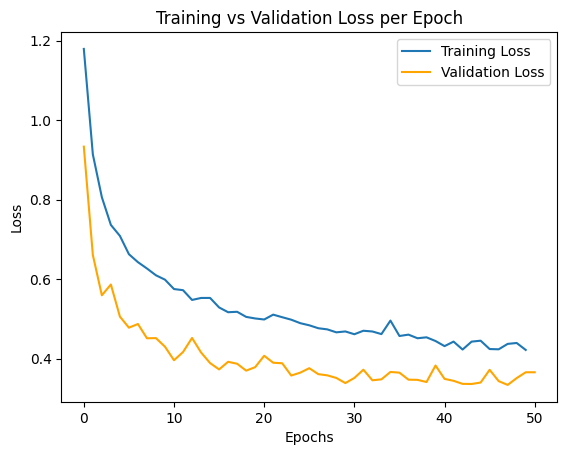

In [31]:
evaluator.plot_loss_history(best_models, best_model_name)

In [32]:
# evaluator.predict_on_val(
#     val_dataset=transformed_val_dataset,
#     best_models=best_models,
#     best_model_name=best_model_name,
# )

# **Key Conclusions:**

# **High Model Accuracy:**

**Validation Accuracy:** The model achieved a validation accuracy of 85.53%. This suggests that the model generalizes well to unseen data, correctly predicting the outcomes in most cases.

**Evaluation on Test Set:** The model achieved an accuracy of 0.855 on the test set. Additionally, other evaluation metrics, such as Balanced Accuracy (0.8549), F1 Score (0.8545), Precision (0.8566), and Recall (0.8553), demonstrate that the model performs consistently across different aspects of prediction quality.

# **Optimal Hyperparameters:**

**Best Architecture:** A 3-layer architecture with convolutional layers [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)] performed the best.

**Hyperparameter Tuning:** The optimal model was achieved with a batch size of 16, a learning rate of 0.001, ReLU activation functions, and Adam optimizer. A dropout rate of 0.1 helped to prevent overfitting, and MaxPooling (kernel size = 2, stride = 2, padding = 0) was used to reduce the spatial dimensions effectively.

# **Regularization and Loss Function:**

**Regularization:** The use of dropout after each hidden layer (with a dropout rate of 0.1) proved to be effective in preventing overfitting. This acts as a form of regularization by randomly dropping units during training.

**Optimizer and Loss Function:** The combination of Adam optimizer and the MSE loss function resulted in effective optimization of the model parameters.

**Cross-Validation Score:**
The cross-validation score for the best model was 0.783, indicating that while the model performed well during cross-validation, there is still some room for improvement in terms of generalization.
